In [1]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import metrics, feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import torch

## for bert language model
import transformers
from transformers import AutoTokenizer, AutoModel

In [2]:
''' The following shows the result of training various non-neural network models on the original version of the 
Kannada set. models are trained on an bert vectorizer'''

' The following shows the result of training various non-neural network models on the original version of the \nKannada set. models are trained on an bert vectorizer'

In [3]:
# import data
kan_train = pd.read_table("../../datasets/task_a/kan_sentiment_train.tsv")
kan_dev = pd.read_table("../../datasets/task_a/kan_sentiment_dev.tsv")

In [4]:
kan_train = kan_train.rename(columns={'category': 'y'})
kan_dev = kan_dev.rename(columns={'category': 'y'})

In [5]:
kan_dev

,text,y
0,Binduge saryagi ugithidira good go ahead we a...,Mixed feelings
1,yen song guru ...super,Positive
2,my fevorat story,not-Kannada
3,Super ತೋಗರಿ ತೀಪ್ಪ,Positive
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...,Positive
...,...,...
686,@Nandi Parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,Negative
687,Hugi guru badethawke,Negative
688,Trending no.1 wow,Positive
689,@Troll Stupid Fans naanu adikke kano helthirod...,Positive


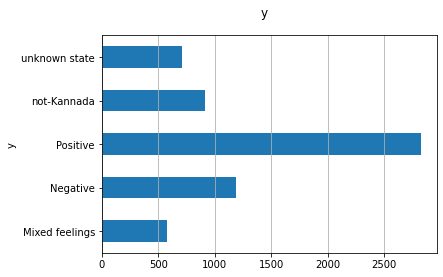

In [6]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
kan_train.groupby("y").count().plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [7]:
# Now we can define our training data and our dev data as well as targets
train = kan_train
test = kan_dev

y_train = kan_train['y'].values
y_test = kan_dev['y'].values


In [8]:
# for ensemble: 
results = pd.DataFrame(kan_dev['y'])

# Gettint text embeddings from the bert model

In [9]:
# I'll be using the embeddings from the multilinngual bert model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
model = AutoModel.from_pretrained('bert-base-multilingual-uncased').to(device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# We will start by gathering the embeddings for the validation set
cls_val_list = []
batch_size = 1000

for batch_number, batch_test in test.groupby(np.arange(len(test)) // batch_size):
    # tokanizing the text
    tokenized_val = tokenizer(batch_test["text"].values.tolist() , padding = 'max_length', truncation = True,  return_tensors="pt", max_length=256)

    # move on device (GPU)
    tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}

    # get the cls hidden state
    with torch.no_grad():
        hidden_val = model(**tokenized_val)
            
    #get only the [CLS] hidden states
    cls_val = hidden_val.last_hidden_state[:,0,:]
    cls_val = cls_val.to("cpu")
    cls_val_list.append(cls_val)
    del cls_val
    del hidden_val
    del tokenized_val
    
    torch.cuda.empty_cache()

cls_val_list_final = []
for i in range(len(cls_val_list)):
    for j in range(len(cls_val_list[i])):
        cls_val_list_final.append(cls_val_list[i][j])

/home/ubuntu/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [11]:
# Get embeddigns for the trainins set
cls_train_list = []
batch_size = 1000

for batch_number, batch_train in train.groupby(np.arange(len(train)) // batch_size):
    # tokanizing the text
    tokenized_train = tokenizer(batch_train["text"].values.tolist() , padding = 'max_length', truncation = True,  return_tensors="pt", max_length=256)

    # move on device (GPU)
    tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}

    # get the cls hidden state
    with torch.no_grad():
        hidden_train = model(**tokenized_train)
            
    #get only the [CLS] hidden states
    cls_train = hidden_train.last_hidden_state[:,0,:]
    cls_train = cls_train.to("cpu")
    cls_train_list.append(cls_train)
    del cls_train
    del hidden_train
    del tokenized_train
    
    torch.cuda.empty_cache()

cls_train_list_final = []
for i in range(len(cls_train_list)):
    for j in range(len(cls_train_list[i])):
        cls_train_list_final.append(cls_train_list[i][j])

/home/ubuntu/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [12]:
len(cls_val_list_final)

691

In [13]:
len(cls_train_list_final)

6212

In [14]:
X_train = torch.stack(cls_train_list_final)
X_train = pd.DataFrame(X_train)
X_test = torch.stack(cls_val_list_final)
X_test = pd.DataFrame(X_test)

y_train = kan_train['y'].values
y_test = kan_dev['y'].values

# Training a cat boost classifier

In [15]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(
    iterations=200, 
    learning_rate=.5, 
    #loss_function='CrossEntropy'
)


In [16]:
## train classifier
cat.fit(X_train, y_train)
predicted = cat.predict(X_test)
results['cat_boost_original_bert'] = predicted
predicted_prob = cat.predict_proba(X_test)

0:	learn: 1.3895172	total: 600ms	remaining: 1m 59s
1:	learn: 1.3076110	total: 971ms	remaining: 1m 36s
2:	learn: 1.2552652	total: 1.35s	remaining: 1m 28s
3:	learn: 1.2149302	total: 1.73s	remaining: 1m 24s
4:	learn: 1.1813786	total: 2.1s	remaining: 1m 21s
5:	learn: 1.1593006	total: 2.47s	remaining: 1m 19s
6:	learn: 1.1388784	total: 2.84s	remaining: 1m 18s
7:	learn: 1.1186722	total: 3.21s	remaining: 1m 17s
8:	learn: 1.0995352	total: 3.6s	remaining: 1m 16s
9:	learn: 1.0824102	total: 3.96s	remaining: 1m 15s
10:	learn: 1.0682363	total: 4.32s	remaining: 1m 14s
11:	learn: 1.0562534	total: 4.69s	remaining: 1m 13s
12:	learn: 1.0370299	total: 5.05s	remaining: 1m 12s
13:	learn: 1.0283381	total: 5.42s	remaining: 1m 11s
14:	learn: 1.0183963	total: 5.78s	remaining: 1m 11s
15:	learn: 1.0094619	total: 6.14s	remaining: 1m 10s
16:	learn: 0.9980200	total: 6.49s	remaining: 1m 9s
17:	learn: 0.9863364	total: 6.85s	remaining: 1m 9s
18:	learn: 0.9766232	total: 7.2s	remaining: 1m 8s
19:	learn: 0.9641959	total: 

161:	learn: 0.2988750	total: 58.4s	remaining: 13.7s
162:	learn: 0.2962089	total: 58.8s	remaining: 13.3s
163:	learn: 0.2939657	total: 59.1s	remaining: 13s
164:	learn: 0.2922534	total: 59.5s	remaining: 12.6s
165:	learn: 0.2911775	total: 59.8s	remaining: 12.3s
166:	learn: 0.2895971	total: 1m	remaining: 11.9s
167:	learn: 0.2865408	total: 1m	remaining: 11.5s
168:	learn: 0.2846583	total: 1m	remaining: 11.2s
169:	learn: 0.2833809	total: 1m 1s	remaining: 10.8s
170:	learn: 0.2821942	total: 1m 1s	remaining: 10.4s
171:	learn: 0.2798444	total: 1m 1s	remaining: 10.1s
172:	learn: 0.2787164	total: 1m 2s	remaining: 9.72s
173:	learn: 0.2769268	total: 1m 2s	remaining: 9.36s
174:	learn: 0.2753210	total: 1m 3s	remaining: 9s
175:	learn: 0.2737459	total: 1m 3s	remaining: 8.64s
176:	learn: 0.2725411	total: 1m 3s	remaining: 8.28s
177:	learn: 0.2711176	total: 1m 4s	remaining: 7.92s
178:	learn: 0.2698085	total: 1m 4s	remaining: 7.56s
179:	learn: 0.2684095	total: 1m 4s	remaining: 7.2s
180:	learn: 0.2667743	total

Accuracy: 0.59
Auc: 0.78
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.22      0.10      0.13        52
      Negative       0.58      0.47      0.52       139
      Positive       0.65      0.78      0.71       321
   not-Kannada       0.58      0.56      0.57       110
 unknown state       0.38      0.33      0.35        69

      accuracy                           0.59       691
     macro avg       0.48      0.45      0.46       691
  weighted avg       0.57      0.59      0.57       691



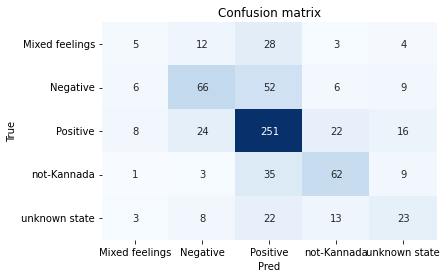

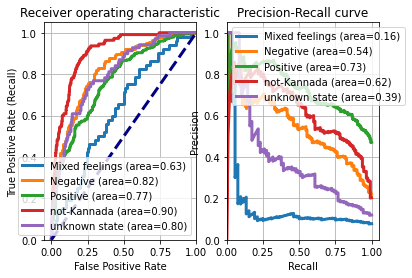

In [17]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Training a Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=150, n_estimators=15, max_features=768)

In [19]:

## train classifier
forest.fit(X_train, y_train)
## test
predicted = forest.predict(X_test)
results['forest_original_bert'] = predicted
predicted_prob = forest.predict_proba(X_test)

Accuracy: 0.56
Auc: 0.74
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.23      0.10      0.14        52
      Negative       0.50      0.47      0.49       139
      Positive       0.61      0.76      0.67       321
   not-Kannada       0.56      0.54      0.55       110
 unknown state       0.46      0.19      0.27        69

      accuracy                           0.56       691
     macro avg       0.47      0.41      0.42       691
  weighted avg       0.53      0.56      0.54       691



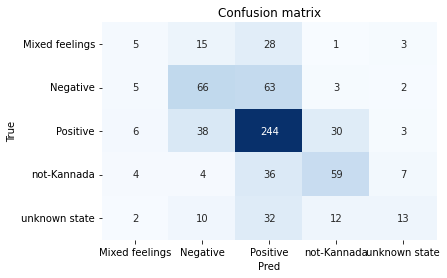

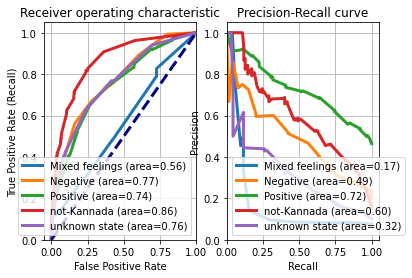

In [20]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# fitting a logistic regression classifier

In [21]:
from sklearn.linear_model import LogisticRegression
log =LogisticRegression(random_state=0, max_iter= 190)

In [22]:
## pipeline

## train classifier
log.fit(X_train, y_train)
## test
predicted = log.predict(X_test)
results['log_original_bert'] = predicted
predicted_prob = log.predict_proba(X_test)

/home/ubuntu/pyenv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.61
Auc: 0.82
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.25      0.04      0.07        52
      Negative       0.55      0.51      0.53       139
      Positive       0.65      0.80      0.72       321
   not-Kannada       0.61      0.67      0.64       110
 unknown state       0.47      0.26      0.34        69

      accuracy                           0.61       691
     macro avg       0.51      0.46      0.46       691
  weighted avg       0.58      0.61      0.58       691



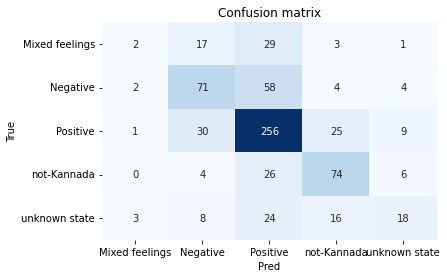

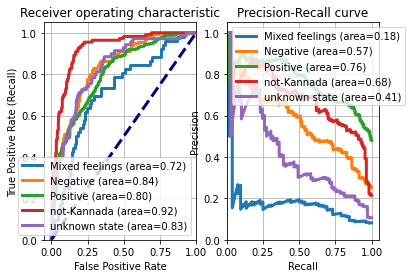

In [23]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# training a k-neighboot classifier

In [24]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=8, weights='distance')

In [25]:

## train classifier
neigh.fit(X_train, y_train)
## test
predicted = neigh.predict(X_test)
results['neigh_original_bert'] = predicted
predicted_prob = neigh.predict_proba(X_test)

Accuracy: 0.62
Auc: 0.77
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.32      0.13      0.19        52
      Negative       0.58      0.52      0.55       139
      Positive       0.66      0.80      0.72       321
   not-Kannada       0.61      0.65      0.63       110
 unknown state       0.56      0.32      0.41        69

      accuracy                           0.62       691
     macro avg       0.55      0.48      0.50       691
  weighted avg       0.60      0.62      0.60       691



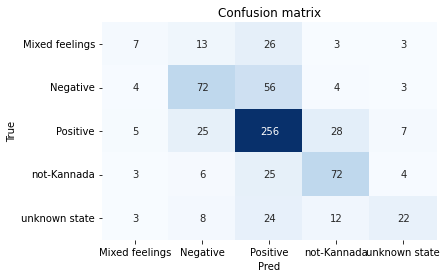

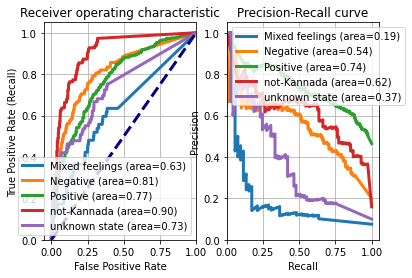

In [26]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Ensemble

In [27]:
results.replace(['Negative', 'Positive','not-Kannada', 'Mixed feelings','unknown state' ], [0,1,2,3,4], inplace=True)
results['original_majority_label_bert'] = results[results.columns[1:]].mode(axis=1)[0].astype(int)
results.replace([0,1,2,3,4], ['Negative', 'Positive','not-Kannada', 'Mixed feelings','unknown state' ], inplace=True)
results.to_csv('kan_results_original_bert.tsv', sep="\t", index = False)

                precision    recall  f1-score   support

Mixed feelings       0.50      0.08      0.13        52
      Negative       0.60      0.60      0.60       139
      Positive       0.65      0.84      0.74       321
   not-Kannada       0.64      0.56      0.60       110
 unknown state       0.58      0.26      0.36        69

      accuracy                           0.64       691
     macro avg       0.59      0.47      0.49       691
  weighted avg       0.62      0.64      0.60       691



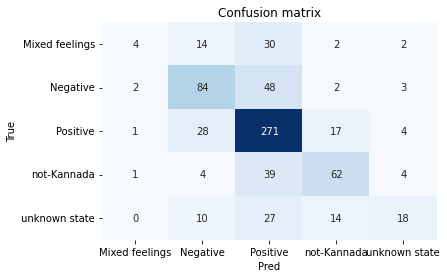

In [28]:
## Plot confusion matrix
print(metrics.classification_report(results['y'], results['original_majority_label_bert']))
cm = metrics.confusion_matrix(results['y'], results['original_majority_label_bert'])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

In [77]:
from googletrans import Translator, constants
translator = Translator()
mal_test = pd.read_table("../../datasets/task_a/mal_sentiment_test.tsv")
mal_list= mal_test['text'].tolist()
mal_list_temp = []
for i in range(len(mal_list)):
    result = translator.translate(mal_list[i], src ='ml', dest = 'kn')
    mal_list_temp.append(result.text)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961


In [78]:
translated_mal_test = mal_test['id']

In [79]:
mal_list_temp = pd.DataFrame(mal_list_temp)

In [80]:
mal_list_temp.rename(columns={0: "text"}, inplace=True)

In [81]:
mal_test = pd.concat([translated_mal_test, mal_list_temp], axis=1)

In [82]:
mal_test

,id,text
0,Mal_1,ಟೀಸೇರಿನು ಕೂರಚ್ ಸಮಯ ಕೂಡಿ ಮಾತ್ರ. ಕಾಯಲು ಸಾಧ್ಯವಿಲ್ಲ..
1,Mal_2,ನಂತರ ಕಥೆಯ ಹಾದಿ ಬದಲಾಯಿತು...
2,Mal_3,ಮೂತನ್ ಟ್ರೈಲರ್ ಏಕೆ ಟ್ರೆಂಡಿಂಗ್ ಪಟ್ಟಿಯಲ್ಲಿಲ್ಲ?
3,Mal_4,ಇತ್ತೀಚಿನ ದಿನಗಳಲ್ಲಿ ಕೇರಳದಲ್ಲಿ 944k ವೀಕ್ಷಣೆಗಳನ್ನ...
4,Mal_5,Maass.trailer ennu paranja ithaanU makkale.......
...,...,...
1957,Mal_1958,ಎಕ್ಸ್ ಪ್ರೆಶನ್ ನೋಡಿದರೆ ಮೂಗು ಕತ್ತರಿಸಿರುವ ಸುದೇವ್ ...
1958,Mal_1959,ನೀವು ನನಗೆ 100 ಇಷ್ಟಗಳನ್ನು ನೀಡಬಹುದೇ?
1959,Mal_1960,ನನ್ನಯಿ ಒನ್ನು ಪೋಲಿಯುನ್ನ ಲಕ್ಷ್ಣಂ ಉಂಡೆ...ಥ್ರಿಲ್ ಮ...
1960,Mal_1961,ಅತಿಕಂ ಎದುತ್ತು ಕಾಯತ್ತಿ ವೆಕ್ಕೆಂದ....ದಿಕ್ಕಿಗೆ ಕಟ್...


In [29]:
#kan_test = pd.read_table("../../datasets/task_a/kan_sentiment_test.tsv")

In [30]:
#kan_test

,id,text
0,Kan_1,ಈ ಹಾಡನ್ನು ಹಾಡಿದ ವಿಜಯ ಪ್ರಕಾಶ voice ಯಾರಿಗೆಲ್ಲಾ ಇ...
1,Kan_2,Jai D Boss
2,Kan_3,Signature move
3,Kan_4,Super song bro
4,Kan_5,Wow Super agi helidira sir
...,...,...
763,Kan_764,Thu thukali trailer
764,Kan_765,Siri gannadam galge haakbitallapa Thu yaro ni...
765,Kan_766,ನಾವೇನಾದರು ಸ್ವಾಬಿಮಾನಿಯಾಗಿ ಬದುಕನ್ನು ಕಟ್ಟಿಕೊಳ್ಳಲು...
766,Kan_767,ದಿಯಾ ನೀವು ಸೋಷಿಯಲ್ ಮೀಡಿಯಾ ಅಲ್ಲಿ ಕಾಣ್ತಿಲ್ಲ.nದಯವಿ...


In [83]:
results = pd.DataFrame(mal_test['id'])

In [84]:
results

,id
0,Mal_1
1,Mal_2
2,Mal_3
3,Mal_4
4,Mal_5
...,...
1957,Mal_1958
1958,Mal_1959
1959,Mal_1960
1960,Mal_1961


In [85]:
# get embeddings for test set
cls_test_list = []
batch_size = 1000

for batch_number, batch_test in mal_test.groupby(np.arange(len(mal_test)) // batch_size):
    # tokanizing the text
    tokenized_test = tokenizer(batch_test["text"].values.tolist() , padding = 'max_length', truncation = True,  return_tensors="pt", max_length=256)

    # move on device (GPU)
    tokenized_test = {k:torch.tensor(v).to(device) for k,v in tokenized_test.items()}

    # get the cls hidden state
    with torch.no_grad():
        hidden_test = model(**tokenized_test)
            
    #get only the [CLS] hidden states
    cls_test = hidden_test.last_hidden_state[:,0,:]
    cls_test = cls_test.to("cpu")
    cls_test_list.append(cls_test)
    del cls_test
    del hidden_test
    del tokenized_test
    
    torch.cuda.empty_cache()

cls_test_list_final = []
for i in range(len(cls_test_list)):
    for j in range(len(cls_test_list[i])):
        cls_test_list_final.append(cls_test_list[i][j])

/home/ubuntu/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [86]:
X_test = torch.stack(cls_test_list_final)
X_test = pd.DataFrame(X_test)

In [87]:
predicted_cat = cat.predict(X_test)
results['cat_boost_original_bert'] = predicted_cat

In [88]:
predicted_forest = forest.predict(X_test)
results['forest_original_bert'] = predicted_forest

In [89]:
predicted_log = log.predict(X_test)
results['log_original_bert'] = predicted_log

In [90]:
predicted_neigh = neigh.predict(X_test)
results['neigh_original_bert'] = predicted_neigh

In [91]:
results

,id,cat_boost_original_bert,forest_original_bert,log_original_bert,neigh_original_bert
0,Mal_1,Positive,Positive,Positive,Positive
1,Mal_2,Positive,Positive,Positive,Positive
2,Mal_3,unknown state,Mixed feelings,Positive,Positive
3,Mal_4,Positive,Mixed feelings,Positive,Positive
4,Mal_5,Negative,Negative,Negative,Negative
...,...,...,...,...,...
1957,Mal_1958,Positive,Positive,Positive,Positive
1958,Mal_1959,Positive,Mixed feelings,Positive,Positive
1959,Mal_1960,Positive,Positive,Positive,Positive
1960,Mal_1961,Negative,Positive,Positive,Negative


In [92]:
results.replace(['Negative', 'Positive','not-Kannada', 'Mixed feelings','unknown state' ], [0,1,2,3,4], inplace=True)
results['original_majority_label_bert'] = results[results.columns[1:]].mode(axis=1)[0].astype(int)
results.replace([0,1,2,3,4], ['Negative', 'Positive','not-Kannada', 'Mixed feelings','unknown state' ], inplace=True)


In [93]:
results['original_majority_label_bert'].value_counts()

Positive          1747
Negative           203
Mixed feelings       7
unknown state        3
not-Kannada          2
Name: original_majority_label_bert, dtype: int64

In [75]:
results.to_csv('final_tam_results.tsv', sep="\t", index = False)